# CLUSTER 6 CLASSES

This notebook analyzes network traffic data using clustering techniques to identify patterns in network attacks. We'll explore two different approaches:
1. Standard K-means clustering with 6 clusters
2. Modified approach using DBSCAN with merged DoS/DDoS categories

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tabulate import tabulate
from sklearn.utils import resample
from rich import print

In [2]:
# Save and Load Clustering Models or Labels
def save_cluster(model, filename):
    """Save a clustering model to a file."""
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

def save_labels(labels, filename):
    """Save clustering labels to a file."""
    with open(filename, 'wb') as file:
        pickle.dump(labels, file)

def load_cluster(filename):
    """Load a clustering model from a file."""
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model

def load_labels(filename):
    """Load clustering labels from a file."""
    with open(filename, 'rb') as file:
        labels = pickle.load(file)
    return labels

## 2. Data Preprocessing Functions

In [3]:
def balance_dataset(df, method='median_multiplier', multiplier=2, column='category'):
    """
    Balance the dataset by downsampling majority classes.
    
    Parameters:
    - df: pandas DataFrame with 'category' or 'attack' column
    - method: str, approach for calculating threshold
    - multiplier: float, multiplier for threshold calculation
    
    Returns:
    - balanced DataFrame
    """
    counts = df[column].value_counts()

    # Calculate threshold
    if method == 'median_multiplier':
        threshold = np.median(counts) * multiplier
    elif method == 'mean_multiplier':
        threshold = np.mean(counts) * multiplier
    elif method == 'quantile':
        threshold = counts.quantile(0.75)
    else:
        raise ValueError("Method must be 'median_multiplier', 'mean_multiplier', or 'quantile'")
    
    # Balance categories
    balanced_dfs = []
    for value in counts.index:
        value_df = df[df[column] == value]
        if len(value_df) > threshold:
            value_df = resample(value_df, replace=False, n_samples=int(threshold), random_state=42)
        balanced_dfs.append(value_df)
    
    balanced_df = pd.concat(balanced_dfs)
    comparison_data = [
        [value, counts[value], balanced_df[column].value_counts().get(value, 0)]
        for value in sorted(counts.index)
    ]

    comparison_data.sort(key=lambda x: x[1], reverse=True)

    print(tabulate(
        comparison_data,
        headers=[column, 'Original', 'After Balance'],
        tablefmt='psql'
    ))
    
    return balanced_df.sample(frac=0.1, random_state=37)

def preprocess_data_cluster(df, **kwargs):
    """Scale and balance data."""

    method = kwargs.get('method', 'median_multiplier')
    multiplier = kwargs.get('multiplier', 2)
    column = kwargs.get('column', 'category')

    df = balance_dataset(df, method=method, multiplier=multiplier, column=column)

    scaler = StandardScaler()
    scaled_df = scaler.fit_transform(df.drop(['is_benign', 'category', 'attack'], axis=1))


    return scaled_df, df[column]

## 3. Clustering Functions

In [4]:
def kmeans_clustering(data, n_clusters):
    """Perform K-Means clustering and evaluate results."""
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=37) 
    labels = kmeans.fit_predict(data)
    print(f"K-Means Clustering with {n_clusters} clusters completed.")
    return labels, kmeans

# DBSCAN Clustering
def dbscan_clustering(data, eps_values = [0.1, 0.3, 0.5, 0.7, 0.9], min_samples_values = [5, 10, 15, 20]):
    """Perform DBSCAN clustering with different parameters and save the best result."""
    best_score = -1
    best_labels = None
    best_eps = None
    best_min_samples = None
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(data)
            score = silhouette_score(data, labels)
            
            if score > best_score:
                best_score = score
                best_labels = labels
                best_eps = eps
                best_min_samples = min_samples
    
    print(f"Best DBSCAN Clustering with eps={best_eps}, min_samples={best_min_samples} completed.")
    return best_labels

# Evaluate Clustering
def evaluate_clustering(data, labels):
    """Evaluate clustering using different metrics."""
    silhouette = silhouette_score(data, labels)
    calinski = calinski_harabasz_score(data, labels)
    davies = davies_bouldin_score(data, labels)
    
    return silhouette, calinski, davies

In [5]:
def visualize_clusters(data, cluster_labels_list, true_labels, method_names):
    """
    Visualize clustering results alongside true labels using t-SNE.
    Enhanced for better readability and comparison.
    """
    tsne = TSNE(n_components=2, random_state=37)
    reduced_data = tsne.fit_transform(data)
    
    n_methods = len(cluster_labels_list)
    _, axes = plt.subplots(n_methods, 2, figsize=(20, 8*n_methods))
    
    # If only one method, wrap axes in 2D array for consistent indexing
    if n_methods == 1:
        axes = axes.reshape(1, 2)
    
    
    for idx, (method_labels, method_name) in enumerate(zip(cluster_labels_list, method_names)):
        # Plot clustering results
        cluster_scatter = sns.scatterplot(
            x=reduced_data[:, 0],
            y=reduced_data[:, 1],
            hue=method_labels,
            palette='Set3',
            alpha=0.7,
            s=100,  # Larger point size
            ax=axes[idx, 0]
        )
        axes[idx, 0].set_title(f'{method_name}\nClustering Results', fontsize=12, pad=15)
        cluster_scatter.legend(title="Clusters", bbox_to_anchor=(1.02, 1), loc='upper left', title_fontsize=10)
        
        # Plot true labels
        true_scatter = sns.scatterplot(
            x=reduced_data[:, 0],
            y=reduced_data[:, 1],
            hue=true_labels,
            palette='Spectral',
            alpha=0.7,
            s=100,  # Larger point size
            ax=axes[idx, 1]
        )
        axes[idx, 1].set_title('True Labels\nGround Truth', fontsize=12, pad=15)
        true_scatter.legend(title="Categories", bbox_to_anchor=(1.02, 1), loc='upper left', title_fontsize=10)
        
        # Remove axis labels as they're not meaningful in t-SNE space
        axes[idx, 0].set_xlabel('')
        axes[idx, 0].set_ylabel('')
        axes[idx, 1].set_xlabel('')
        axes[idx, 1].set_ylabel('')
        
        # Add grid for better readability
        axes[idx, 0].grid(True, alpha=0.3)
        axes[idx, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [6]:
df = pd.read_csv('/kaggle/input/dataset/train_sel_hclust.csv')
#df = pd.read_csv('../dataset/train_sel_hclust.csv')

+------------+------------+-----------------+
| category   |   Original |   After Balance |
|------------+------------+-----------------|
| DDoS       |     581986 |          300339 |
| DoS        |     284552 |          284552 |
| BENIGN     |     192732 |          192732 |
| MQTT       |     107607 |          107607 |
| RECON      |      52541 |           52541 |
| SPOOFING   |      16047 |           16047 |
+------------+------------+-----------------+

K-Means Clustering with 6 clusters completed.

K-Means Clustering with 5 clusters completed.

Best DBSCAN Clustering with eps=0.9, min_samples=20 completed.

Clustering Evaluation Summary:

+-----------+--------------------+---------------------------+------------------------+
| Method    |   Silhouette Score |   Calinski-Harabasz Score |   Davies-Bouldin Score |
+===========+====================+===========================+========================+
| K-Means-6 |           0.406376 |                  1061.88  |                1.35952 |
+-----------+--------------------+---------------------------+------------------------+
| K-Means-5 |           0.24753  |                   958.578 |                1.36105 |
+-----------+--------------------+---------------------------+------------------------+
| DBSCAN    |           0.464315 |                   352.89  |                1.85978 |
+-----------+--------------------+---------------------------+------------------------+

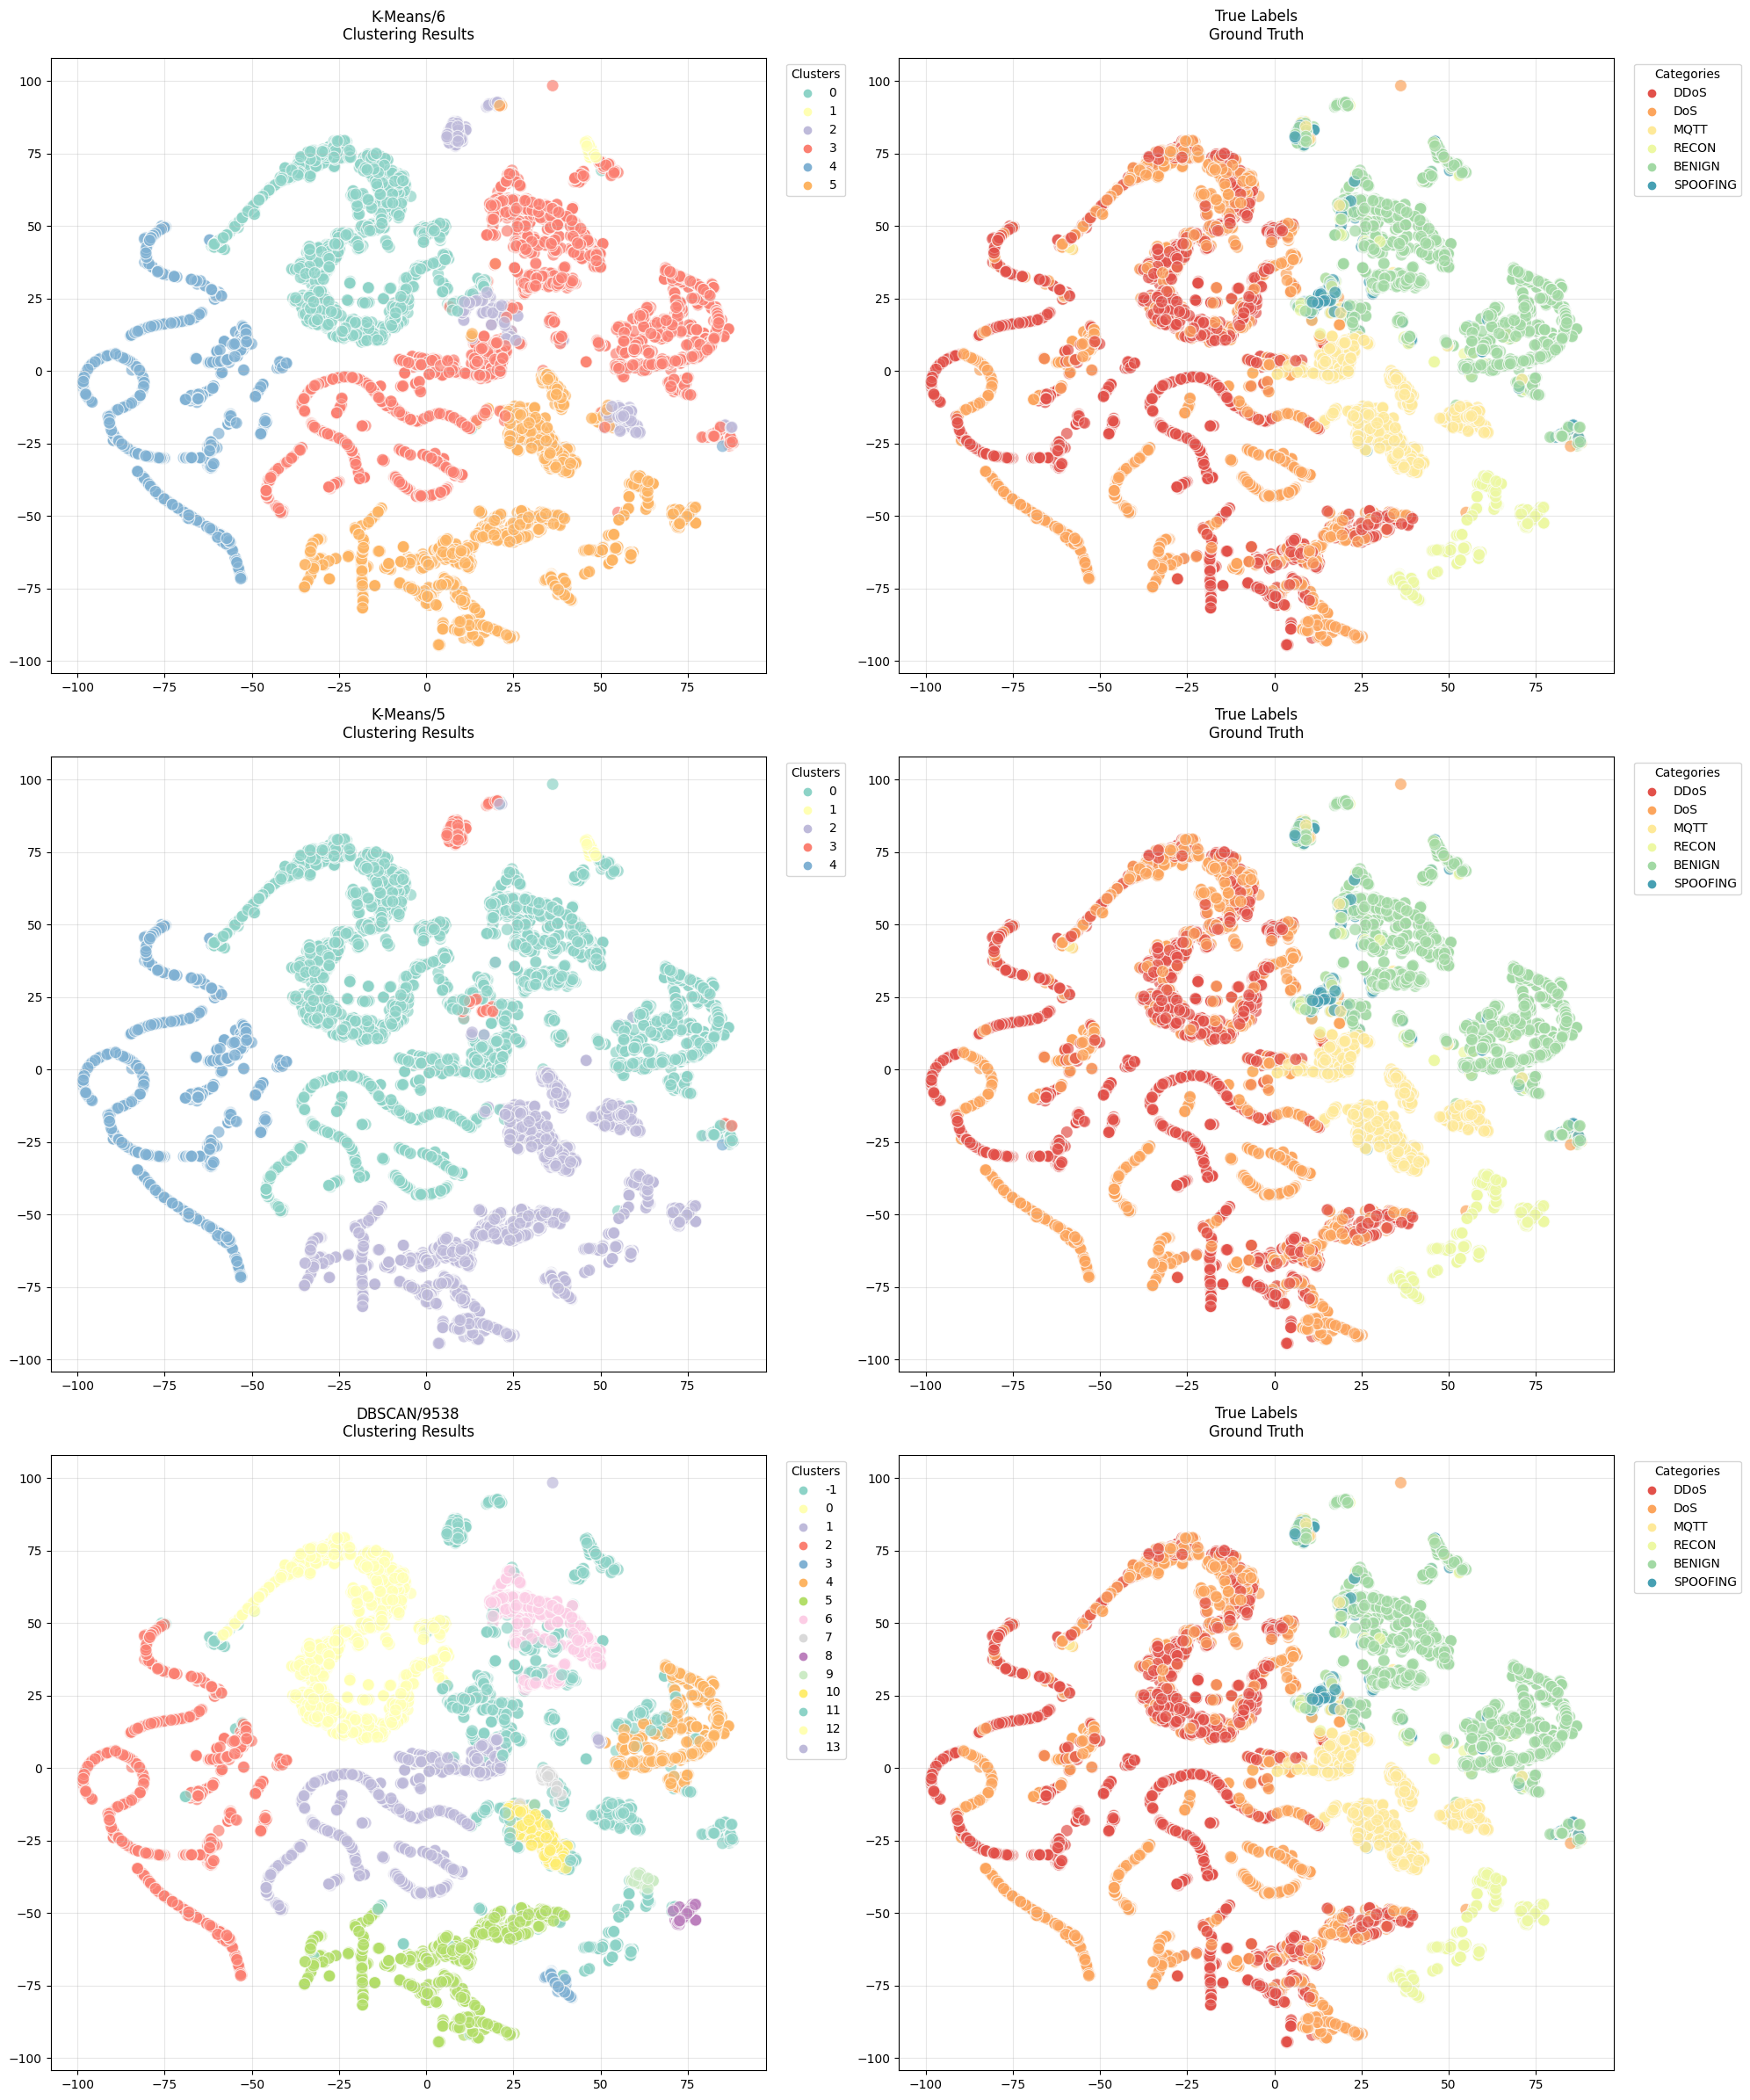

In [7]:
scaled_data, labels = preprocess_data_cluster(df)

In [ ]:
# Perform and evaluate K-Means with 6 clusters
kmeans_6_labels, kmeans_6 = kmeans_clustering(scaled_data, n_clusters=6)
kmeans_6_scores = evaluate_clustering(scaled_data, kmeans_6_labels)
save_cluster(kmeans_6, "kmeans_6.pkl")
save_labels(kmeans_6_labels, "kmeans_6_labels.pkl")

In [ ]:
# Perform and evaluate K-Means with 5 clusters
kmeans_5_labels, kmeans_5 = kmeans_clustering(scaled_data, n_clusters=5)
kmeans_5_scores = evaluate_clustering(scaled_data, kmeans_5_labels)
save_cluster(kmeans_5, "kmeans_5.pkl")
save_labels(kmeans_5_labels, "kmeans_5_labels.pkl")

In [ ]:
# Perform and evaluate DBSCAN
dbscan_labels = dbscan_clustering(scaled_data)
dbscan_scores = evaluate_clustering(scaled_data, dbscan_labels)
save_labels(dbscan_labels, "dbscan_labels.pkl")

In [ ]:
# Display Evaluation Results in a Table
evaluation_table = [
    ["K-Means-6", *kmeans_6_scores],
    ["K-Means-5", *kmeans_5_scores],
    ["DBSCAN", *dbscan_scores]
]

headers = ["Method", "Silhouette Score", "Calinski-Harabasz Score", "Davies-Bouldin Score"]
print("\nClustering Evaluation Summary:")
print(tabulate(evaluation_table, headers=headers, tablefmt="grid"))

# Visualize Clustering Results Side by Side
visualize_clusters(
    scaled_data,
    [kmeans_6_labels, kmeans_5_labels, dbscan_labels],
    labels,
    ["K-Means/6","K-Means/5", f"DBSCAN/{len(dbscan_labels)}"]
)